# Unmaned Aerial Vehicle 

In this notebook, we adapt the UAV example found in ["Categorical Semantics of Cyber-Physical Systems Theory"](https://arxiv.org/abs/2010.08003)

The system consists of an aircraft with an elevator flap, a sensor that measures the pitch angle, and an attitude controller. The controller receives the measured pitch and angle and adjusts the elevator to reach the desired orientation. 

![image](https://ctms.engin.umich.edu/CTMS/Content/AircraftPitch/System/Modeling/figures/flightdynamics.png)

In [1]:
# Activate the require environment
using Pkg
    # Use path relative to notebook
Pkg.activate("../../AlgebraicContracts.jl")

  Activating project at `~/Desktop/Categorical_Semantics/AlgebraicContracts.jl`


In [2]:
# Access submodule
using AlgebraicContracts.ContractedMachines

In [3]:
# Wiring diagrams
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
# Dynamics
using DifferentialEquations
using AlgebraicDynamics.DWDDynam
using LabelledArrays
# Plotting
using Plots
# Contracts
using IntervalSets  

## Wiring diagram architecture
We can divide the system into three separate modules: the dynamics of the aircraft, the controller, and the sensor. Each module is represented as a box inside a wiring diagram. 

The boxes must have a name and a list of input and output ports. At each port, we can attach a wire that communicates with the rest of the system. For future reference, let us label the variables of the system:
- _s_ = current pitch angle of the vehicle
- _s'_ = pitch angle as measured by the sensor
- _c_ = controller output to the elevator
- _e_ = external bias of the sensor
- _d_ = external input to the controller

We can assign these variables to the boxes using arrays of symbols. The first array represents the inputs, while the second array represents the outputs.

In [4]:
s = Box(:sensor    , [:s, :e]      , [:s_prime])
c = Box(:controller, [:s_prime, :d], [:c])
d = Box(:dynamics  , [:c]          , [:s])

Box(:dynamics, [:c], [:s])

We now create a wiring diagram and populate with it the boxes. Like before, a wiring diagram also requires a list of input and output variables. Each box assigned to a diagram is given an id number. This number is provided in the order in which the boxes are added to the diagram.

In [5]:
# Diagram:           Inputs, Outputs <- Ports of entire diagram
UAV = WiringDiagram([:e,:d], [:s])

# Associate boxes to diagram
sensor     = add_box!(UAV, s)
controller = add_box!(UAV, c)
dynamics   = add_box!(UAV, d)

3

Wires are used to create connections between the boxes. This process requires the port number of a particular box. For example, the sensor has inputs "s" and "e". Given their location in the input array, "s" has port number 1, while "e" has a port number "2". 

In [6]:
add_wires!(UAV, [
  # Net Inputs      
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  # Connections
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  # Net Outputs
  (dynamics,1) => (output_id(UAV),1)
])

The wiring diagram is now complete and can be visualized. For more detailed information on constructing wiring diagrams, see the Catlab documentation: [Wiring diagram basics](https://algebraicjulia.github.io/Catlab.jl/latest/generated/wiring_diagrams/wiring_diagram_basics/)

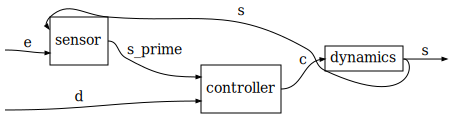

In [7]:
to_graphviz(UAV, orientation=LeftToRight, labels=true)

## Wiring diagram semantics
Each box can be assigned behavior through an update and readout function. The update function calculates the derivative of the state using the current state of the box __u__, a vector of external inputs __x__,  external parameters __p__, and time __t__. The function _must_ output a vector whose number of elements is the number of states. For more information on the readout and update function, see the documentation for [AlgebraicDynamics](https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/). 

The controller and sensor are modeled as first-order systems with the response rates _λs_ and _λc_ accordingly. The controller uses the sensor's output _sl_ multiplied by a proportional gain _kθ_ to create a feedback loop that deflects the elevator.  

The aircraft dynamics are taken from this tutorial on system behavior: [Aircraft pitch: System modeling](https://ctms.engin.umich.edu/CTMS/index.php?example=AircraftPitch&section=SystemModeling). The states are the angular velocity of the aircraft _q_, the angle of attack _α_, and the pitch angle _θ_.

In [8]:
# update functions: 
equation_sensor(u, x, p, t)  = [ -p.λs*(u[1] - x[1] - x[2]) ];        # x = [θ, e] -> [Pitch angle, pitch offset]

equation_control(u, x, p, t) = [ -p.λc*(u[1] + p.kθ*x[1] - x[2]) ];   # x = [Sl, d] -> [sensor output, control input]

equation_dynamic(u, x, p, t) = [ -0.313*u[1] +  56.7*u[2] +  0.232*x[1],    # α -> Angle of attack
                                -0.0139*u[1] - 0.426*u[2] + 0.0203*x[1],    # q -> Angular velocity
                                                56.7*u[2]              ];   # θ -> Pitch angle    
                                                                            # x = [Sc] -> Controller output 
# Parameters:
# λs = Response rate of sensor
# λc = Response rate of controller
# kθ = Gain of controller. Causes a feedback loop

The readout functions define the output of each box. They use the state vector __u__, external parameters __p__, and time __t__ to calculate an output vector. Each element of the output vector is assigned to the outputs of a box. If a box has two output ports, the output vector _must_ have two elements. 

For our system, the sensor shall output its measurement _sl_, the controller shall output a command _sc_, and the dynamics shall output the pitch angle _θ_. 

In [9]:
# Readout functions:  [select specific state]
readout_sensor(u, p, t)  = [ u[1] ];  # sl
readout_control(u, p, t) = [ u[1] ];  # sc
readout_dynamic(u, p ,t) = [ u[3] ];  # θ

# Static contracts
We assign contracts to the boxes by defining intervals of acceptable values. As each box has input and output ports, we require intervals for each side. 

The restrictions for the controller can be determined through the conditions that cause the aircraft to stall. By finding the steady-state angle of attack using dynamics equations, we can find the maximum elevator deflection as a function of stall angle. A stall angle of 15° yields a maximum elevator deflection of 11.059°. At the same time, most aircraft never exceed a pitch angle of 20° and never go below -30°.   

</br>
<center> -30° ≤ s' ≤ 20° </center>  
<center> -11.059° ≤ d ≤ 11.059°  </center> 

The sensor has the restrictions to measure and output an acute angle. The pitch angle is a Euler angle, so values over 90° do not make sense. The bias in the sensor should also be kept below 5° for the sensor to remain reasonably accurate.  

</br>
<center> -90° ≤ s' ≤ 90° </center>   
<center> -5° ≤ e ≤ 5° </center> 

Lastly, we note that the actual state of the vehicle is determined by its dynamics, so it is ultimately unrestricted. However, the elevator cannot be deflected too much due to mechanical limits and flow seperation. For plain flaps, this occurs at around 20°.   

</br>
<center> -∞ < s < ∞ </center>  
<center> -20° < c < 20° </center>   

In [10]:
# Note: angles have been converted to radians

# contract intervals                             # Variable:
sensor_in = [ -1.57..1.57, -0.087..0.087 ]       # [s, e]
sensor_out = [ -1.57.. 1.57 ]                    # [s_prime]

controller_in = [ -0.523..0.349, -0.193..0.193 ] # [s_prime, d]
controller_out = [ -0.193..0.193 ]               # [c] 

dynamics_in = [ -0.349..0.349 ]                  # [c]
dynamics_out = [ -Inf..Inf ];                    # [s]

We use the update and readout functions, the contracts, and the number of states, to create a machine for each box.

In [11]:
# Machines for each box in diagram:
                                            # Inputs, States, Outputs
sensor_machine = ContractedMachine{Float64}( sensor_in, 1, sensor_out, 
                                            equation_sensor, readout_sensor );

controller_machine = ContractedMachine{Float64}( controller_in, 1, controller_out, 
                                            equation_control, readout_control ); 

dynamics_machine = ContractedMachine{Float64}( dynamics_in, 3, dynamics_out, 
                                            equation_dynamic, readout_dynamic ); 

Next we combine these machines using the wiring diagram to obtain a machine with the entire system's behavior.

In [12]:
# Output composition
comp = oapply( UAV, [sensor_machine, controller_machine, dynamics_machine] )

Note: intervals do not overlap between sensor (id=1) and controller (id=2) at wire "s_prime":
                    [-1.57,1.57] ∩ [-0.523,0.349] ≠ [-1.57,1.57]
Note: intervals do not overlap between dynamics (id=3) and sensor (id=1) at wire "s":
                    ℝ ∩ [-1.57,1.57] ≠ ℝ


StaticContract( [-0.087,0.087] × [-0.193,0.193] × ℝ )[Machine]

# Evaluate system 
We can solve the dynamics of the system using an ODE solver. To this end, we require a set of constant parameters, the initial conditions of the states, and some initial inputs. For now, let us disable the controller's gain to observe the open-loop response of the aircraft. 

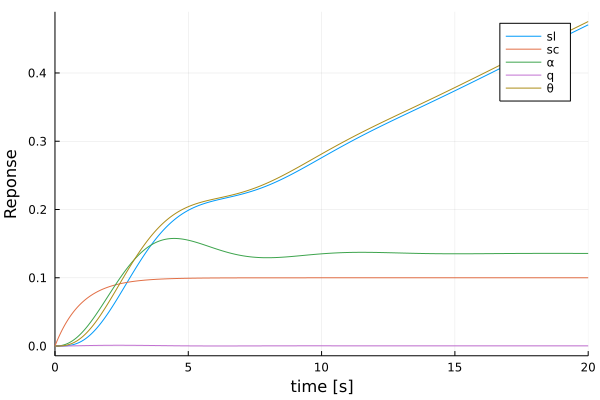

In [13]:
# Initial values
x_init = LVector(e=0.00, d=0.1);               # Inputs: [e, d] -> [θ offset, 𝛿 control input]
u_init = LVector(sl=0, sc=0, α=0, q=0, θ=0);   # States: [sl, sc, α, q, θ]

# Integration interval
t_span = (0, 20); 

# Parameters:
param = (λs = 4,  # Decay constant of sensor
         λc = 1,  # Decay constant of controller
         kθ = 0); # Gain of control input proportional to sensor output. Causes a feedback loop.

# solve system 
sol = solve( ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] );

# Plot behavior
plot(sol, xlabel="time [s]", ylabel="Reponse")

We can check the solution against the contracts using a contract table. By inspecting the graph, we notice that the intervals shown in the table coincide with the plot. After 14 seconds, the controller sees a pitch angle that exceeds 20°. This situation violates the input contract of the controller. 

In [14]:
dict = check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,"s_prime : 14.026997 , 20.000000",
dynamics,,
sensor,,


## Modifed parameters
We can ensure the contracts are satisfied by increasing the controller's gain. Under closed-loop control, the pitch angle does not grow indefinitely and remains within the acceptable interval.

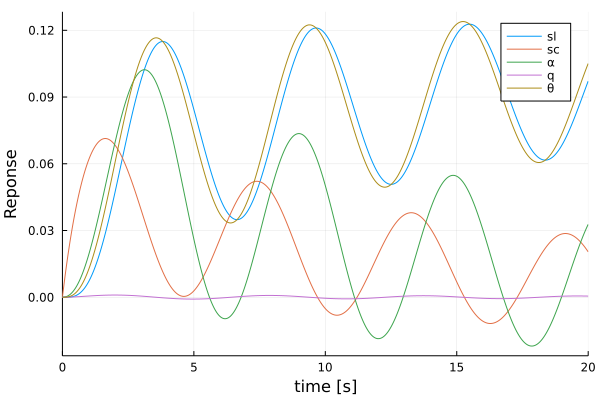

In [15]:
# Parameters:
param = (λs = 4, 
         λc = 1,
         kθ = 1);   # Enable controller gain
                     
x_init = LVector(e=0.0, d=0.1);       
      
# solve system 
sol = solve(ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] )

# Plot behavior
plot(sol, xlabel="time [s]", ylabel="Reponse")

The behavior in the plots can be verified with a contract table. As can be seen, there is no interval during which the contracts are violated. From the controller's perspective, there is no time in which the pitch angle exceeds 20°. 

In [16]:
dict = check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,,
dynamics,,
sensor,,
